In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### parallelization 
options = qt.Options(num_cpus=6)



In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    #"font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{bbm} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

In [3]:

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

In [4]:
def get_Hamiltonian(t, args):

    Omega1 = args["Omega1_t"](t, args)
    Omega2 = args["Omega2_t"](t, args)

    ket0= qt.basis(3,2)
    ket1= qt.basis(3,1)
    ket2= qt.basis(3,0)

    Hamiltonian = (Omega1 * (ket0 * ket1.dag() + ket1 * ket0.dag())
                   + Omega2 * (ket0 * ket2.dag() + ket2 * ket0.dag()))

    return Hamiltonian

def get_Cops(t, args):

    kappa = args["kappa_t"](t, args)

    ket0= qt.basis(3,2)
    ket1= qt.basis(3,1)

    J = np.sqrt(kappa) * ket0 * ket1.dag()
    return J 

def get_Psi0(t, args):

    ket0= qt.basis(3,2)

    return ket0

In [5]:
def Tilted_lindbladian(t, args):

    """
        Evaluate the vectorize tilted Lindbladian at time $t$
    """
    
    #####
    
    H0 = get_Hamiltonian(t, args)
    
    J = get_Cops(t, args)   #### Change this in case of more jump operators 

    s = args["s_t"](t, args)
    
    Ide = qt.qeye(3)
    
    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()

    ########### Flattening the operators
    ####### Non-hermitian evolution 
    ## hot bath
    
    Flat_J = -(1.0/2.0)*(qt.tensor(Ide, J.dag()*J) + qt.tensor((J.dag()*J).trans(), Ide)).full()
    
    ####### Jumps 

    Flat_jump_J = (qt.tensor(J.conj(),J)).full()

    ####### Tilte 
    
    Flat_Jump = np.exp(-s)*Flat_jump_J
                  

    Lst = Flat_H0 + Flat_J + Flat_Jump 

    return Lst.astype(complex)


In [6]:
####### Parameters 

####### Time window 

tau = int(1)
Nsteps = 100
tlist_traj = np.linspace(0, tau, Nsteps)

#######

s = 1

#####
Omega1 = 1.0

Omega2 = Omega1/10
kappa = 4 * Omega1

def Omega1_t(t, args):
    return args["Omega1"]*(1 - 0.5*np.sin(2*np.pi * t/args["tau"]))

def Omega2_t(t, args):
    return args["Omega2"]

def kappa_t(t, args):
    return args["kappa"]

def s_t(t, args):
    return -args["s"]*np.sin(2*np.pi * t/args["tau"])



args_st = {"Omega1":Omega1,
        "Omega2":Omega2,
        "kappa":kappa,
        "Omega1_t":Omega1_t,
        "Omega2_t":Omega2_t,
        "kappa_t":kappa_t,
        "tau":tau,
        "s":s,
        "s_t":s_t}


args_s0 = {"Omega1":Omega1,
        "Omega2":Omega2,
        "kappa":kappa,
        "Omega1_t":Omega1_t,
        "Omega2_t":Omega2_t,
        "kappa_t":kappa_t,
        "tau":tau,
        "s":s,
        "s_t":lambda t, args: 0}

In [7]:

# Define your function
def f(slist, t, args):
    res = []
    for s in slist:
        args["s_t"] = lambda t, args: s
        e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, args), side="right")
        res.append(e_val)
    return np.array(res).real


# Define the function for the Legendre transform
def legendre_transform(k, flist, slist):
    values = -slist*k - flist
    return np.max(values)

def get_phi(klist, slist, t, args):
    flist = f(slist, t, args)
    # Compute the Legendre transform for each k
    return [legendre_transform(k, flist, slist) for k in klist]
    


In [63]:
Tlen = 200

Slen = 1000

slist = np.linspace(-4, 4, Slen)
klist = np.linspace(0, 1, Slen)

tlist = np.linspace(0, args_s0["tau"], Tlen)


phi = []
theta = []
total_time = 0
for i, t in enumerate(tlist):
    t_0 = time.time()
    args_e = args_s0.copy()
    phi.append(get_phi(klist, slist, t, args_e))
    
    
    total_time += (time.time() - t_0)
    print("{}/{} . Time per int. {}".format(i, Tlen, time.time() - t_0, total_time, "\n"))
    

0/200 . Time per int. 0.9188132286071777
1/200 . Time per int. 0.8882761001586914
2/200 . Time per int. 0.8706679344177246
3/200 . Time per int. 0.8579730987548828
4/200 . Time per int. 0.8456501960754395
5/200 . Time per int. 0.852308988571167
6/200 . Time per int. 0.8460149765014648
7/200 . Time per int. 0.877673864364624
8/200 . Time per int. 0.8633878231048584
9/200 . Time per int. 0.8638923168182373
10/200 . Time per int. 0.8680529594421387
11/200 . Time per int. 0.8559513092041016
12/200 . Time per int. 0.8568840026855469
13/200 . Time per int. 0.8494870662689209
14/200 . Time per int. 0.861314058303833
15/200 . Time per int. 0.8497929573059082
16/200 . Time per int. 0.8560681343078613
17/200 . Time per int. 0.8483619689941406
18/200 . Time per int. 0.8521058559417725
19/200 . Time per int. 0.8511471748352051
20/200 . Time per int. 0.8440749645233154
21/200 . Time per int. 0.8575077056884766
22/200 . Time per int. 0.8600771427154541
23/200 . Time per int. 0.8546288013458252
24/20

# Geting the minimum values of the rate function

In [64]:
kmin_list = []


for i, t in enumerate(tlist):
    elem = np.min(phi[i])
    kmin_list.append(klist[np.where(np.isclose(elem, phi[i]))])

In [65]:
max0 = max(klist)
min0 = min(klist)

new_phi = []
new_activity = []
for i, a in enumerate(klist):
    if np.abs(a) >= max0: continue
    else:
        new_phi.append(phi[0][i])
        
        new_activity.append(a)


## Saving

In [66]:
data = args_s0.copy()
data.update({"phi":phi})
data.update({"klist":klist})
data.update({"tlist":tlist})

del data["s_t"]
del data["Omega1_t"]
del data["Omega2_t"]
del data["kappa_t"]

In [67]:
with open('Data_phi_blinking.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()

# Plotting 

## loading other data

In [73]:
with open('Data_blinking_st.pickle', 'rb') as handle:
    data_st = pickle.load(handle)

with open('Data_blinking_s0.pickle', 'rb') as handle:
    data_s0 = pickle.load(handle)

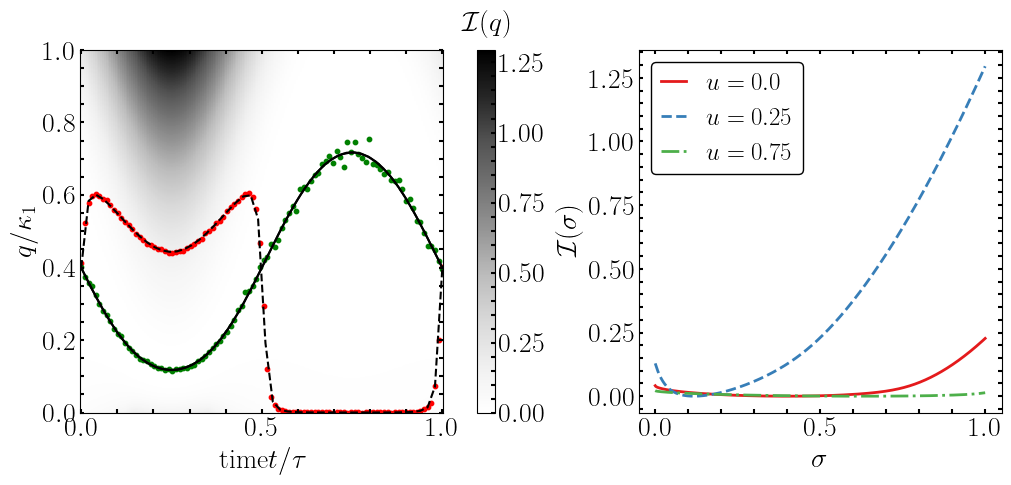

In [75]:

K, T = np.meshgrid(klist, tlist)


# Plot the original function and its Legendre transform
fig, ax = plt.subplots(1,2, figsize=(10, 5), 
                       layout='compressed')


cbar = ax[0].pcolormesh(T, K, np.array(phi).real, cmap="Greys",rasterized=True)
cbar1 = fig.colorbar(cbar, ax=ax[0], pad=.05, fraction=0.05,  orientation='vertical')
cbar1.ax.set_xlabel(r"$\mathcal{I}(q)$", labelpad=-290, va='top')



ax[0].set_xlabel(r"$\mathrm{time }t/\tau$")
ax[0].set_ylabel(r"$q/\kappa_1$")


#ax[0].scatter(np.arange(1000-1)/(1000-1), mean_values[1:], s=1, c="red")

ax[0].plot(tlist, kmin_list, color="black" )

ax[0].scatter(data_s0["Nboxes"], data_s0["act"], color="red", s=10)
ax[0].plot(data_s0["tlist"], data_s0["SCFG_prediction"], color="black")

ax[0].scatter(data_st["Nboxes"], data_st["act"], color="green", s=10)
ax[0].plot(data_st["tlist"], data_st["SCFG_prediction"], color="black", linestyle="--")

ax[0].set_box_aspect(1)

######


ax[1].plot(klist, np.array(phi).real[0],
           label=r"$u = 0.0$", color="#e41a1c", linewidth=2)

ax[1].plot(klist, np.array(phi).real[50]
          , label=r"$u = 0.25$", linewidth=2, linestyle="--",color="#377eb8")

ax[1].plot(klist, np.array(phi).real[174]
          , label=r"$u = 0.75$", linewidth=2, linestyle="-.", color="#4daf4a")


ax[1].set_box_aspect(1)

ax[1].set_xlabel(r"$\sigma$")
ax[1].set_ylabel(r"$\mathcal{I}(\sigma)$")

ax[1].legend(edgecolor="black", 
             framealpha=1,
             handlelength=1,
             borderpad=0.4,
             columnspacing=0.3,
             fontsize=18)

#inset_ax = inset_axes(ax[1], width="40%", height="40%", loc=1)  # loc=2 specifies the upper left corner
#inset_ax.plot(new_activity, new_phi-np.flip(new_phi))


#plt.savefig("entropy_prod.pdf")
